#### Setup

In [507]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.decomposition import PCA # Using to break down df to 2D for visualization

# Styling
sns.set_style("darkgrid")
colour = "viridis"

In [508]:
# Function to set the working directory to the project root
# To make it easy to run project without need for manual path changes
import os
from pathlib import Path

# Find the project root by looking for the .git folder
def find_project_root(current_path: Path):
    for parent in [current_path] + list(current_path.parents):
        if (parent / ".git").exists():
            return parent
    return current_path  # Dont change if not found

project_root = find_project_root(Path.cwd())
os.chdir(project_root)
print("Working directory set to:", os.getcwd())

Working directory set to: c:\Dev\Repos\MLP301-Data-segmentation-using-unsupervised-algorithms


#### Loading the Dataset

In [509]:
# Loading dataset & looking at head
df = pd.read_csv('data/Task1-A1-Dataset.csv')
display(df.head())

C:\Users\foste\AppData\Local\Temp\ipykernel_31976\2763512412.py:2: DtypeWarning: Columns (19) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('data/Task1-A1-Dataset.csv')


,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,...,id,uri,track_href,analysis_url,duration_ms,time_signature,genre,song_name,Unnamed: 0,title
0,0.831,0.814,2,-7.364,1,0.4200,0.0598,0.013400,0.0556,0.3890,...,2Vc6NJ9PW9gD9q343XFRKx,spotify:track:2Vc6NJ9PW9gD9q343XFRKx,https://api.spotify.com/v1/tracks/2Vc6NJ9PW9gD...,https://api.spotify.com/v1/audio-analysis/2Vc6...,124539,4,Dark Trap,Mercury: Retrograde,NaN,NaN
1,0.719,0.493,8,-7.230,1,0.0794,0.4010,0.000000,0.1180,0.1240,...,7pgJBLVz5VmnL7uGHmRj6p,spotify:track:7pgJBLVz5VmnL7uGHmRj6p,https://api.spotify.com/v1/tracks/7pgJBLVz5Vmn...,https://api.spotify.com/v1/audio-analysis/7pgJ...,224427,4,Dark Trap,Pathology,NaN,NaN
2,0.850,0.893,5,-4.783,1,0.0623,0.0138,0.000004,0.3720,0.0391,...,0vSWgAlfpye0WCGeNmuNhy,spotify:track:0vSWgAlfpye0WCGeNmuNhy,https://api.spotify.com/v1/tracks/0vSWgAlfpye0...,https://api.spotify.com/v1/audio-analysis/0vSW...,98821,4,Dark Trap,Symbiote,NaN,NaN
3,0.476,0.781,0,-4.710,1,0.1030,0.0237,0.000000,0.1140,0.1750,...,0VSXnJqQkwuH2ei1nOQ1nu,spotify:track:0VSXnJqQkwuH2ei1nOQ1nu,https://api.spotify.com/v1/tracks/0VSXnJqQkwuH...,https://api.spotify.com/v1/audio-analysis/0VSX...,123661,3,Dark Trap,ProductOfDrugs (Prod. The Virus and Antidote),NaN,NaN
4,0.798,0.624,2,-7.668,1,0.2930,0.2170,0.000000,0.1660,0.5910,...,4jCeguq9rMTlbMmPHuO7S3,spotify:track:4jCeguq9rMTlbMmPHuO7S3,https://api.spotify.com/v1/tracks/4jCeguq9rMTl...,https://api.spotify.com/v1/audio-analysis/4jCe...,123298,4,Dark Trap,Venom,NaN,NaN


In [510]:
# Col 19 has mixed types, taking a closer look
print(f"Col 19 name: {df.columns[19]} \n")
print(df.iloc[:, 19].head(), '\n')
print(df.iloc[:, 19].map(type).value_counts())

# Floats must be the NaN values
NaN_count = df.iloc[:, 19].isna().sum()
print(f"\nNaN count in col 19: {NaN_count}\n")
# Leaving as floats for now to handle NaN values correctly

Col 19 name: song_name 

0                              Mercury: Retrograde
1                                        Pathology
2                                         Symbiote
3    ProductOfDrugs (Prod. The Virus and Antidote)
4                                            Venom
Name: song_name, dtype: object 

song_name
<class 'str'>      21519
<class 'float'>    20786
Name: count, dtype: int64

NaN count in col 19: 20786



##### Dataset Description

In [511]:
# Looking at details of the dataset
print(f"Dataset shape: {df.shape}\n")
print("Information about the dataset:")
display(df.info())
print("\n Descriptive Statistics:")
display(df.describe(include='all'))


Dataset shape: (42305, 22)

Information about the dataset:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 42305 entries, 0 to 42304
Data columns (total 22 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   danceability      42305 non-null  float64
 1   energy            42305 non-null  float64
 2   key               42305 non-null  int64  
 3   loudness          42305 non-null  float64
 4   mode              42305 non-null  int64  
 5   speechiness       42305 non-null  float64
 6   acousticness      42305 non-null  float64
 7   instrumentalness  42305 non-null  float64
 8   liveness          42305 non-null  float64
 9   valence           42305 non-null  float64
 10  tempo             42305 non-null  float64
 11  features          42305 non-null  object 
 12  id                42305 non-null  object 
 13  uri               42305 non-null  object 
 14  track_href        42305 non-null  object 
 15  analysis_url      42305 non-

None


 Descriptive Statistics:


,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,...,id,uri,track_href,analysis_url,duration_ms,time_signature,genre,song_name,Unnamed: 0,title
count,42305.000000,42305.000000,42305.000000,42305.000000,42305.000000,42305.000000,42305.000000,42305.000000,42305.000000,42305.000000,...,42305,42305,42305,42305,42305.000000,42305.000000,42305,21519,20780.000000,20780
unique,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,35877,35877,35877,35877,NaN,NaN,15,15436,NaN,132
top,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,7D5qMGajdfznFcXFArk5VE,spotify:track:7D5qMGajdfznFcXFArk5VE,https://api.spotify.com/v1/tracks/7D5qMGajdfzn...,https://api.spotify.com/v1/audio-analysis/7D5q...,NaN,NaN,Underground Rap,Forever,NaN,Euphoric Hardstyle
freq,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,9,9,9,9,NaN,NaN,5875,14,NaN,1398
mean,0.639364,0.762516,5.370240,-6.465442,0.549462,0.136561,0.096160,0.283048,0.214079,0.357101,...,NaN,NaN,NaN,NaN,250865.846685,3.972580,NaN,NaN,10483.970645,NaN
std,0.156617,0.183823,3.666145,2.941165,0.497553,0.126168,0.170827,0.370791,0.175576,0.233200,...,NaN,NaN,NaN,NaN,102957.713571,0.268342,NaN,NaN,6052.359519,NaN
min,0.065100,0.000243,0.000000,-33.357000,0.000000,0.022700,0.000001,0.000000,0.010700,0.018700,...,NaN,NaN,NaN,NaN,25600.000000,1.000000,NaN,NaN,0.000000,NaN
25%,0.524000,0.632000,1.000000,-8.161000,0.000000,0.049100,0.001730,0.000000,0.099600,0.161000,...,NaN,NaN,NaN,NaN,179840.000000,4.000000,NaN,NaN,5255.750000,NaN
50%,0.646000,0.803000,6.000000,-6.234000,1.000000,0.075500,0.016400,0.005940,0.135000,0.322000,...,NaN,NaN,NaN,NaN,224760.000000,4.000000,NaN,NaN,10479.500000,NaN
75%,0.766000,0.923000,9.000000,-4.513000,1.000000,0.193000,0.107000,0.722000,0.294000,0.522000,...,NaN,NaN,NaN,NaN,301133.000000,4.000000,NaN,NaN,15709.250000,NaN


#### Missing & Duplicates

##### Missing values

Missing values in each column (in %):
Unnamed: 0    50.880511
title         50.880511
song_name     49.133672
dtype: float64


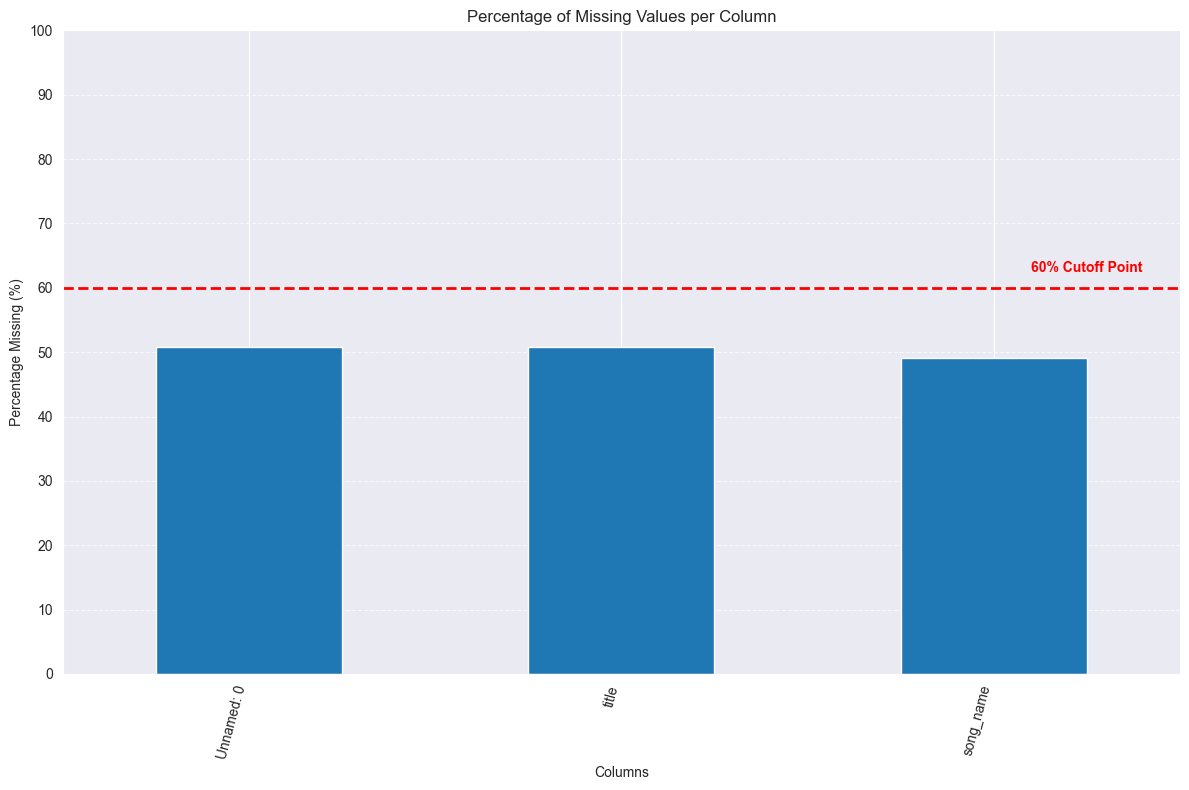

In [512]:
# Calculate the number of missing values per column
missing_values_count = df.isnull().sum()
total_rows = len(df) # Rows in df

# Percentage of missing values per column
missing = (missing_values_count / total_rows) * 100
missing = missing[missing > 0].sort_values(ascending=False)
print('Missing values in each column (in %):')
print(missing)

# Plot
plt.figure(figsize=(12, 8))
missing.plot(kind='bar')
plt.title('Percentage of Missing Values per Column')
plt.ylabel('Percentage Missing (%)')
plt.xlabel('Columns')
plt.xticks(rotation=75, ha="right")
plt.yticks(np.arange(0, 101, 10))
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.axhline(y=60, color='red', linestyle='--', linewidth=2)
plt.text(len(missing) * 0.8, 62, '60% Cutoff Point', color='red', va='bottom', ha='right', fontsize=10, fontweight='bold')
plt.tight_layout()
plt.show()

##### Duplicate Rows

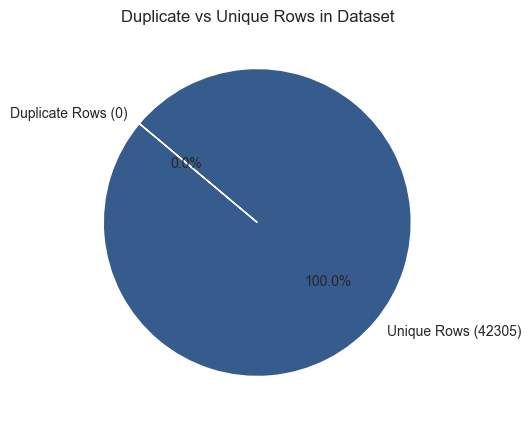

No duplicate rows found in the dataset.
No need to remove duplicates.


In [513]:
# Find duplicate rows
duplicate_rows = df.duplicated()
num_duplicates = duplicate_rows.sum()
num_unique = len(df) - num_duplicates

# Duplicate v Unique Rows Pie Chart
plt.figure(figsize=(5, 5))
plt.pie(
    [num_duplicates, num_unique],
    labels=[f'Duplicate Rows ({num_duplicates})', f'Unique Rows ({num_unique})'],
    autopct='%1.1f%%',
    startangle=140,
    colors=sns.color_palette(colour)
)
plt.title('Duplicate vs Unique Rows in Dataset')
plt.show()

if num_duplicates > 0:
    print(f"Number of duplicate rows: {num_duplicates}")
    print("Sample of duplicate rows:")
    display(df[duplicate_rows].head())
else:
    print("No duplicate rows found in the dataset.")
    print("No need to remove duplicates.")

##### Handling the Values

In [514]:
# Dropping duplicate rows/rows with missing values.
# No point in doing this because i dont use for clustering, oh well already did it
print(f"Shape before cleaning: {df.shape}")
display(df.isnull().sum()[df.isnull().sum() > 0])

# Imputing song_name and title columns with 'Unknown'
df['song_name'] = df['song_name'].fillna('Unknown')
df['title'] = df['title'].fillna('Unknown')
# Dropping 'Unnamed: 0'
df = df.drop(columns=['Unnamed: 0'])

print(f"Shape after cleaning: {df.shape}")
display(df.isnull().sum()[df.isnull().sum() > 0])

Shape before cleaning: (42305, 22)


song_name     20786
Unnamed: 0    21525
title         21525
dtype: int64

Shape after cleaning: (42305, 21)


Series([], dtype: int64)

#### Converting and seperating columns

In [515]:
# Lists to split into
numerical_cols = []
categorical_cols = []
id_cols = []

# Thresholds
HIGH_CARDINALITY_THRESH = 0.95 # 95% unique values probably an ID
CATEGORICAL_INT_THRESH = 30 # Int col with less than 30 unique vals probably categorical

# Splitting cols
for col in df.columns:
    # Floats
    if pd.api.types.is_float_dtype(df[col]):
        numerical_cols.append(col)
    # Integers
    elif pd.api.types.is_integer_dtype(df[col]):
        uniqueness_ratio = df[col].nunique() / len(df)
        # High Cardinnality Check
        if uniqueness_ratio >= HIGH_CARDINALITY_THRESH:
            id_cols.append(col)
        # Categorical Integer Check
        elif df[col].nunique() < CATEGORICAL_INT_THRESH:
            categorical_cols.append(col)
        # Otherwise, treat as numerical
        else:
            numerical_cols.append(col)
    # Strings & Objects 
    else:
        categorical_cols.append(col)
        
# Lists as strings for display
id_str = ', '.join(id_cols)
cat_str = ', '.join(sorted(categorical_cols))
num_str = ', '.join(sorted(numerical_cols))

print("\nColumn Types:")
print(f"\nID Columns ({len(id_cols)}):")
print(id_str)
print(f"\nCategorical Columns ({len(categorical_cols)}):")
print(cat_str)
print(f"\nNumerical Columns ({len(numerical_cols)}):")
print(num_str)

if not id_cols:
    print("\nNo ID-like columns found.")
else:
    df.drop(columns=id_cols, inplace=True)
    print(f"\nDropping {len(id_cols)} ID-like columns for visualizations")


Column Types:

ID Columns (0):


Categorical Columns (11):
analysis_url, features, genre, id, key, mode, song_name, time_signature, title, track_href, uri

Numerical Columns (10):
acousticness, danceability, duration_ms, energy, instrumentalness, liveness, loudness, speechiness, tempo, valence

No ID-like columns found.


### Visualizations

##### Target

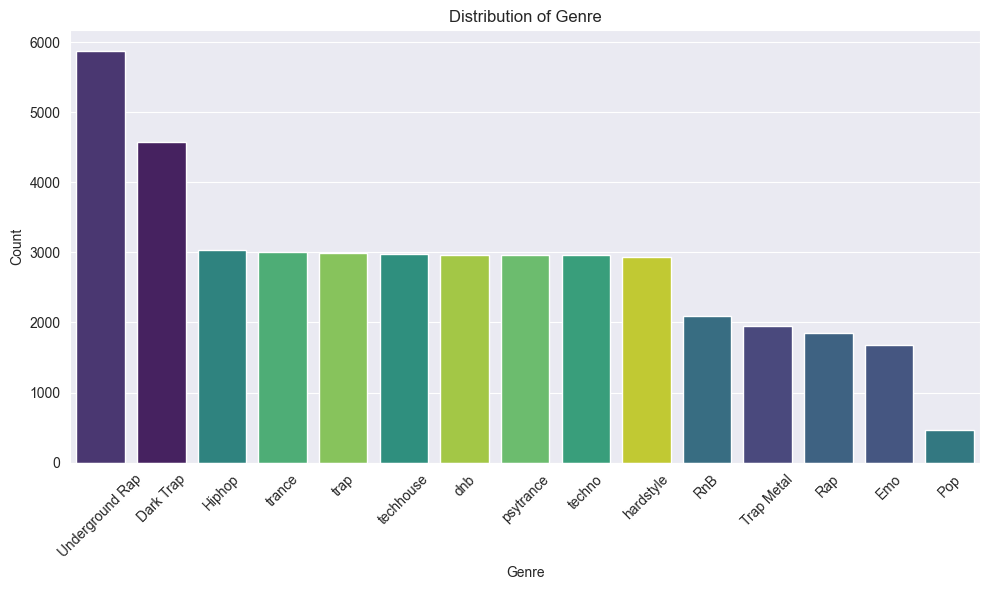

In [516]:
# Distribution of target(Genre) before dropping
plt.figure(figsize=(10, 6))
sns.countplot(data=df,
              x='genre',
              hue='genre',
              order=df['genre'].value_counts().index,
              palette=colour,
              legend=False
              )
plt.title('Distribution of Genre')
plt.xlabel('Genre')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

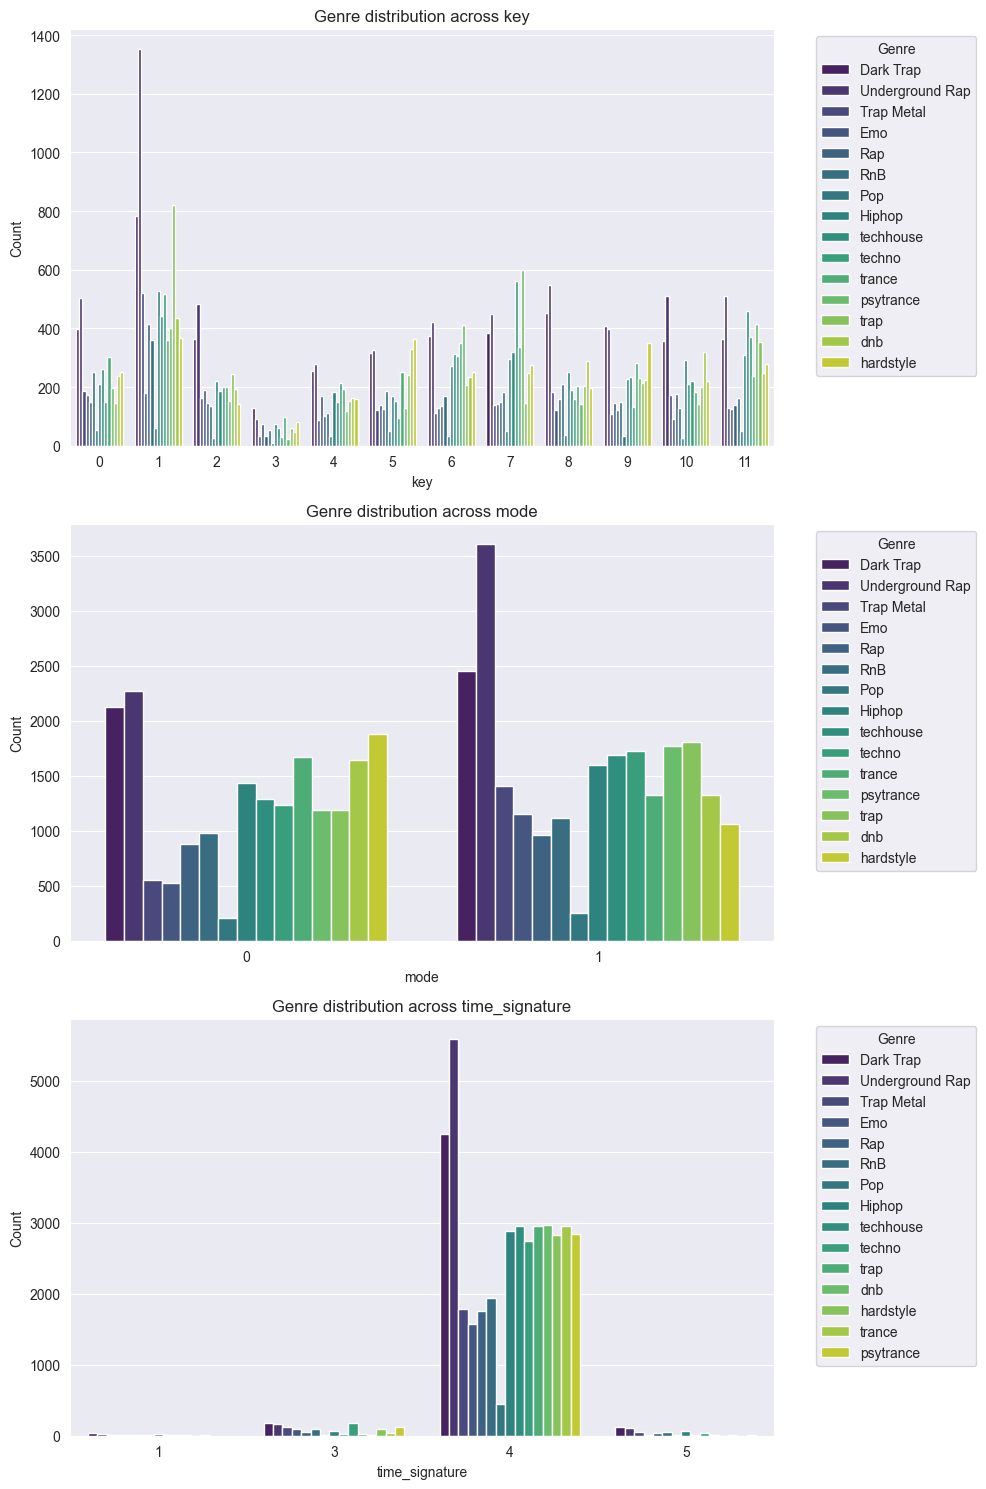

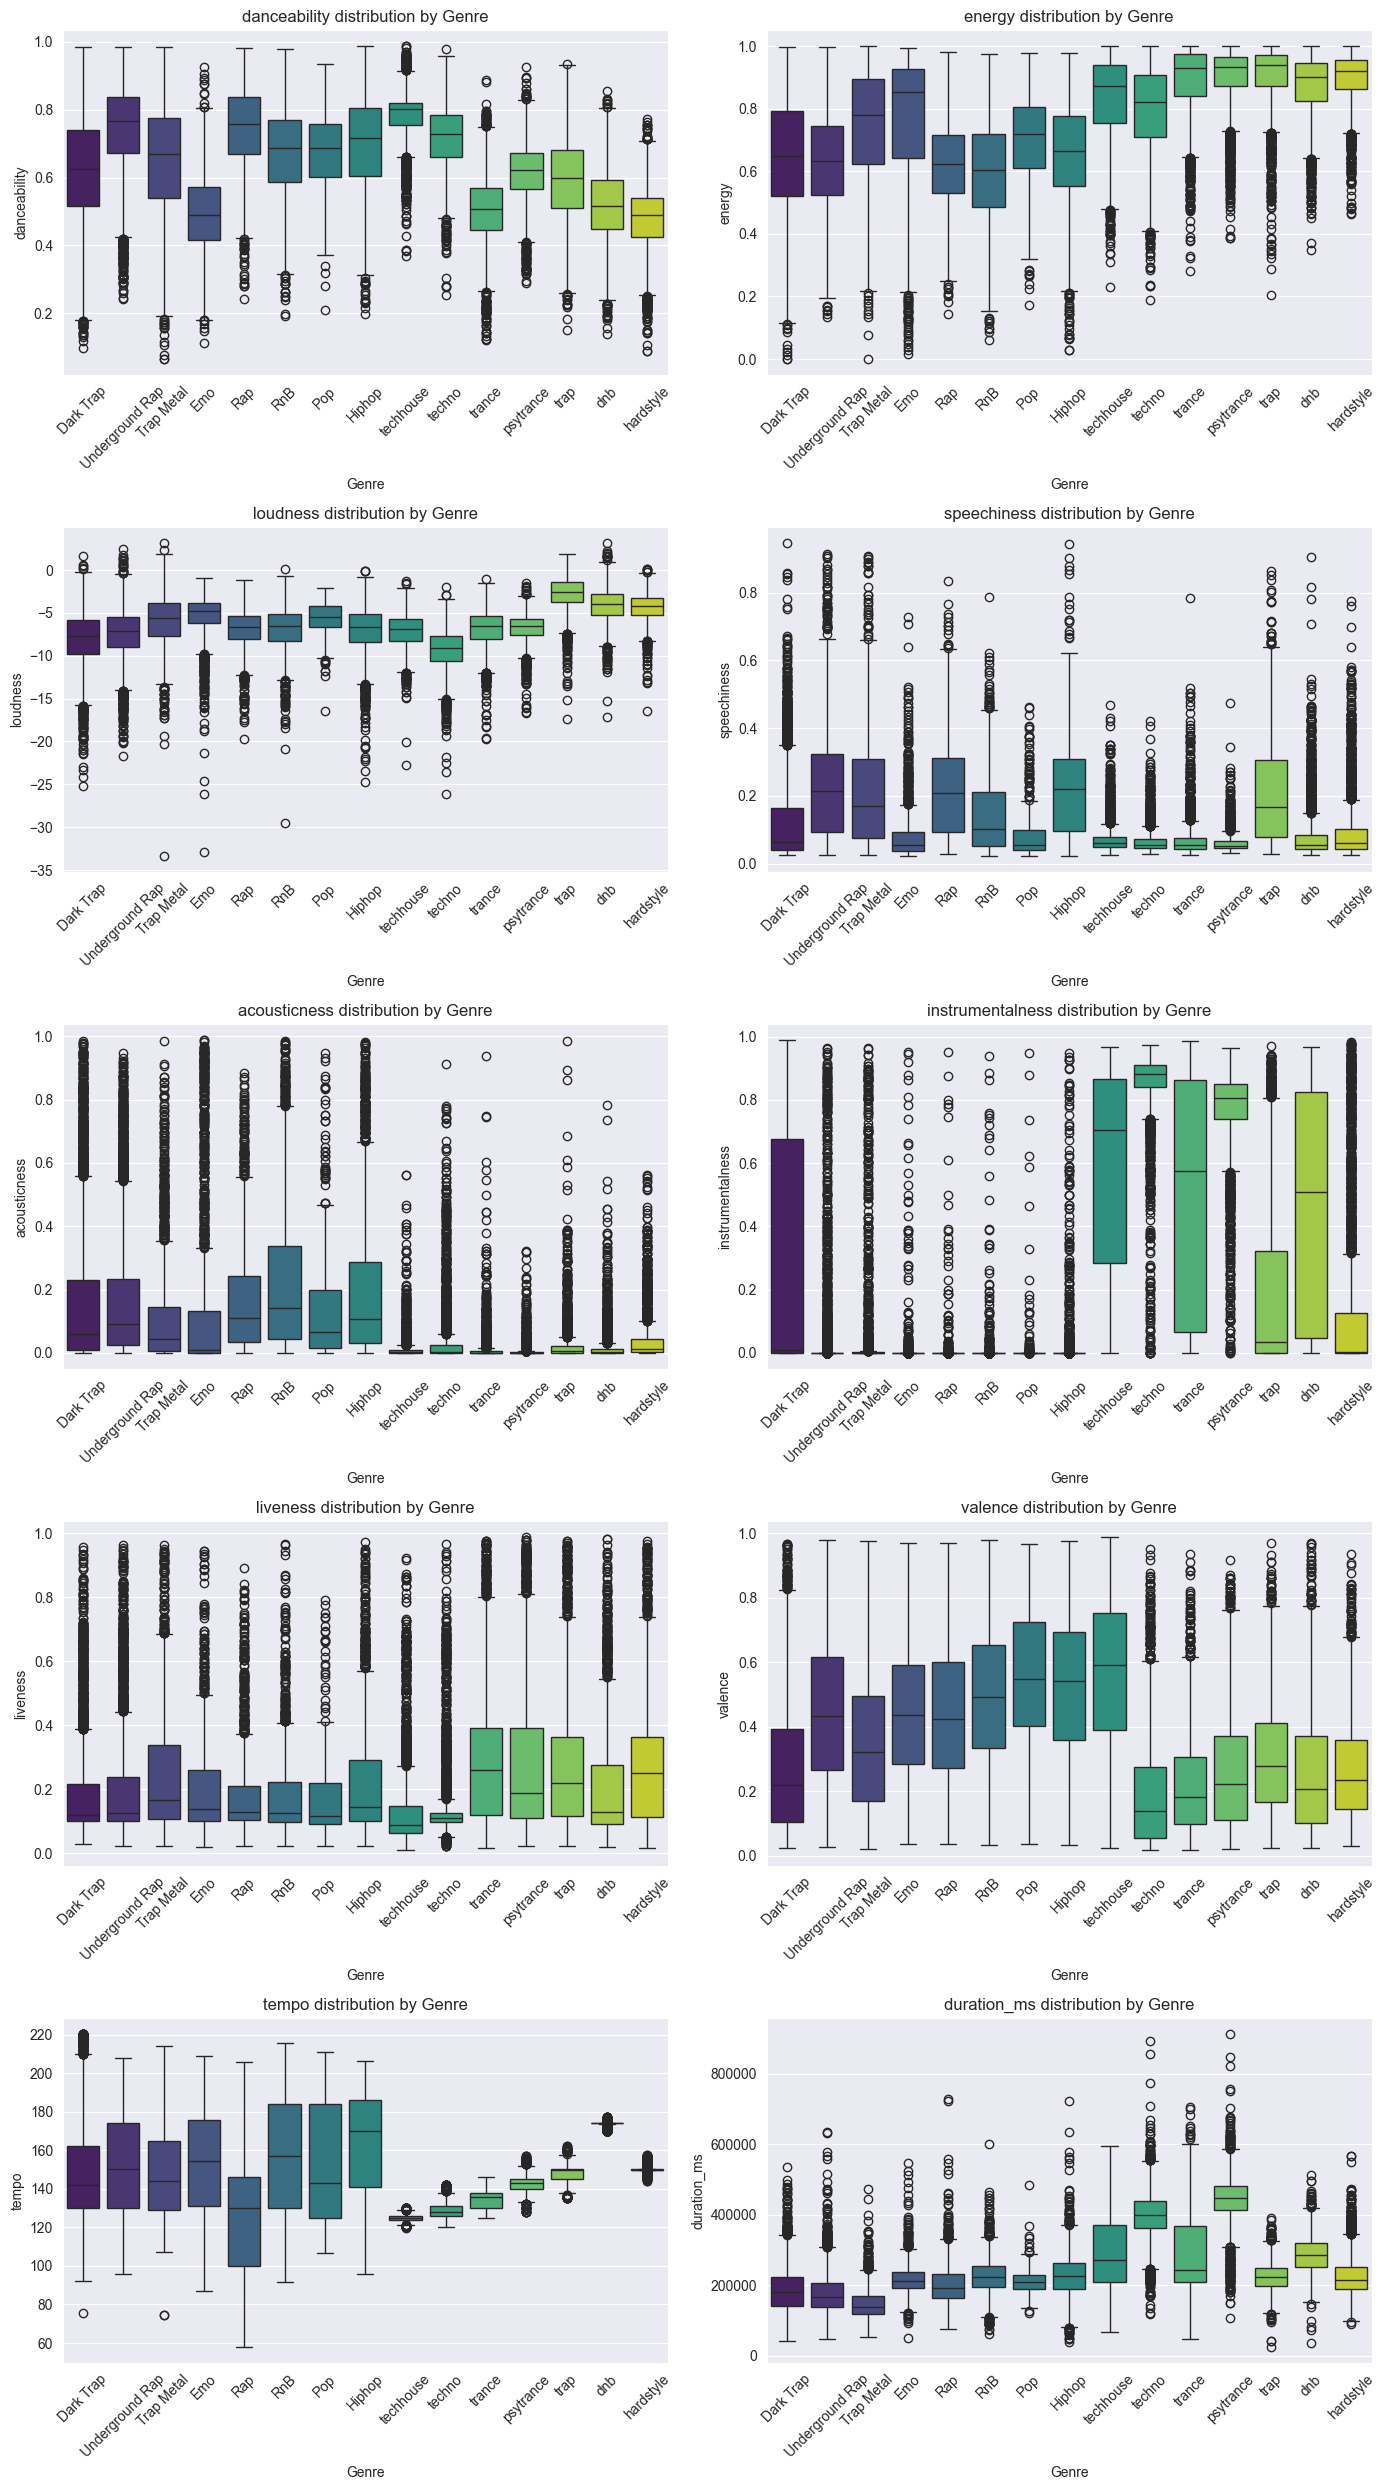

In [517]:
# Genre vs key, mode, and time_signature
categorical_compare = ['key', 'mode', 'time_signature']
n_cols = 1
n_rows = len(categorical_compare)
fig, axes = plt.subplots(n_rows, n_cols, figsize=(10, n_rows * 5))
if n_rows == 1:
    axes = [axes]
for idx, col in enumerate(categorical_compare):
    sns.countplot(data=df, x=col, hue='genre', palette=colour, ax=axes[idx])
    axes[idx].set_title(f'Genre distribution across {col}')
    axes[idx].set_xlabel(col)
    axes[idx].set_ylabel('Count')
    axes[idx].legend(title='Genre', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

# Genre vs numerical features
cols_to_display = [col for col in numerical_cols if col not in ['key', 'mode', 'time_signature']]
n_cols = 2
n_rows = int(np.ceil(len(cols_to_display) / n_cols))
fig, axes = plt.subplots(n_rows, n_cols, figsize=(14, n_rows * 5))
axes = axes.flatten()

for idx, col in enumerate(cols_to_display):
    sns.boxplot(data=df, x='genre', y=col, palette=colour, hue='genre', legend=False, ax=axes[idx])
    axes[idx].set_title(f'{col} distribution by Genre')
    axes[idx].set_xlabel('Genre')
    axes[idx].set_ylabel(col)
    axes[idx].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

##### Categorical Columns

In [518]:
# Dont need these for clustering or visualizations
cols_to_remove = ['id', 'uri', 'track_href', 'analysis_url', 'song_name', 'title', 'features', 'time_signature']
df.drop(columns=cols_to_remove, inplace=True)
# Remove from lists as well
numerical_cols = [col for col in numerical_cols if col not in cols_to_remove]
categorical_cols = [col for col in categorical_cols if col not in cols_to_remove]

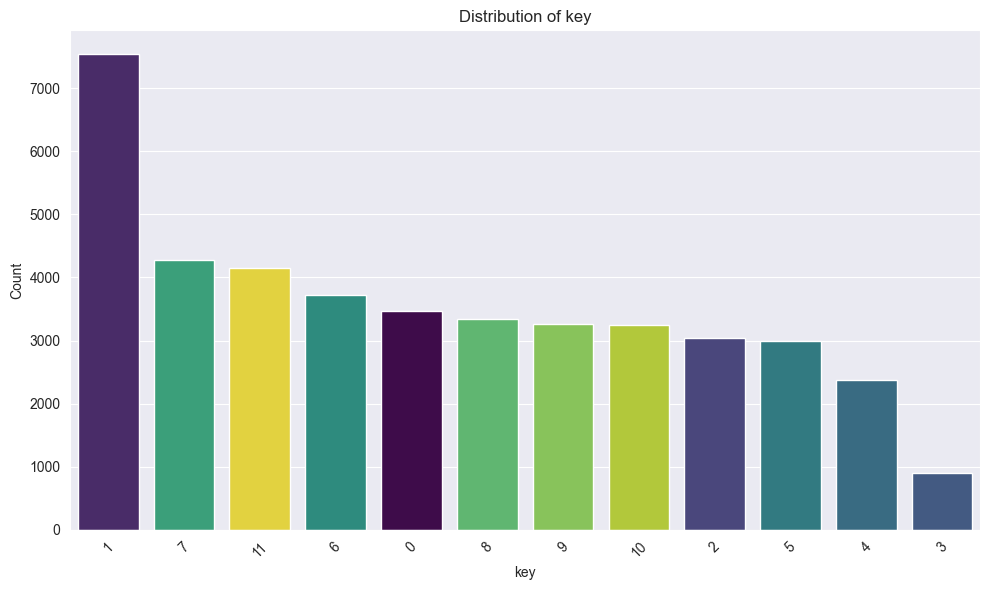

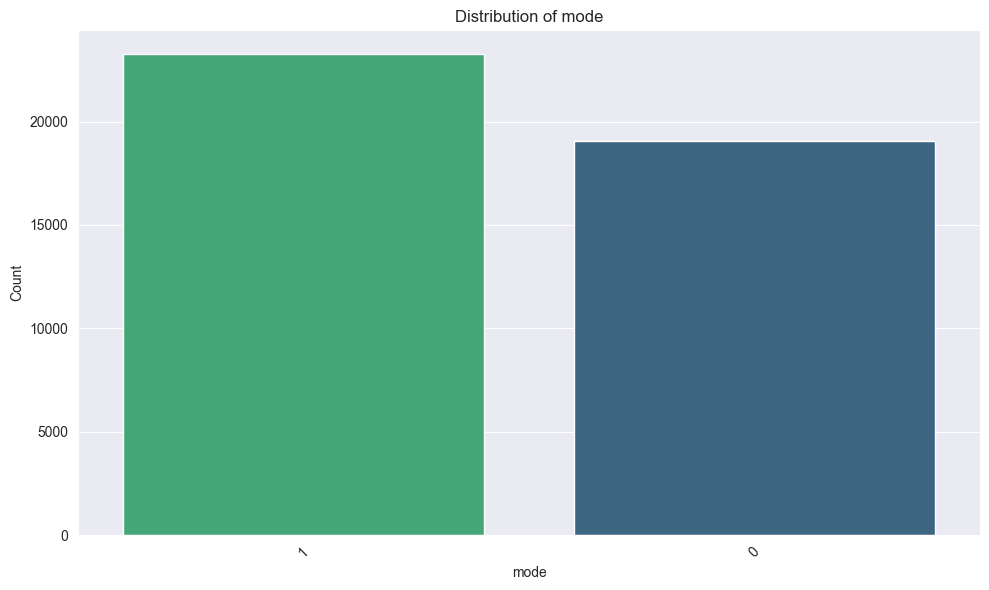

In [519]:
# Distribution of categorical cols
cols_to_display = [col for col in categorical_cols if col != 'genre']
for col in cols_to_display:
    plt.figure(figsize=(10, 6))
    sns.countplot(data=df,
                  x=col,
                  hue=col,
                  order=df[col].value_counts().index,
                  palette=colour,
                  legend=False
                  )
    plt.title(f'Distribution of {col}')
    plt.xlabel(col)
    plt.ylabel('Count')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

##### Numerical Visualizations

Highly skewed features:
- energy (Skewness: -0.74)
- speechiness (Skewness: 1.67)
- acousticness (Skewness: 2.53)
- instrumentalness (Skewness: 0.75)
- liveness (Skewness: 1.78)
- duration_ms (Skewness: 0.95)


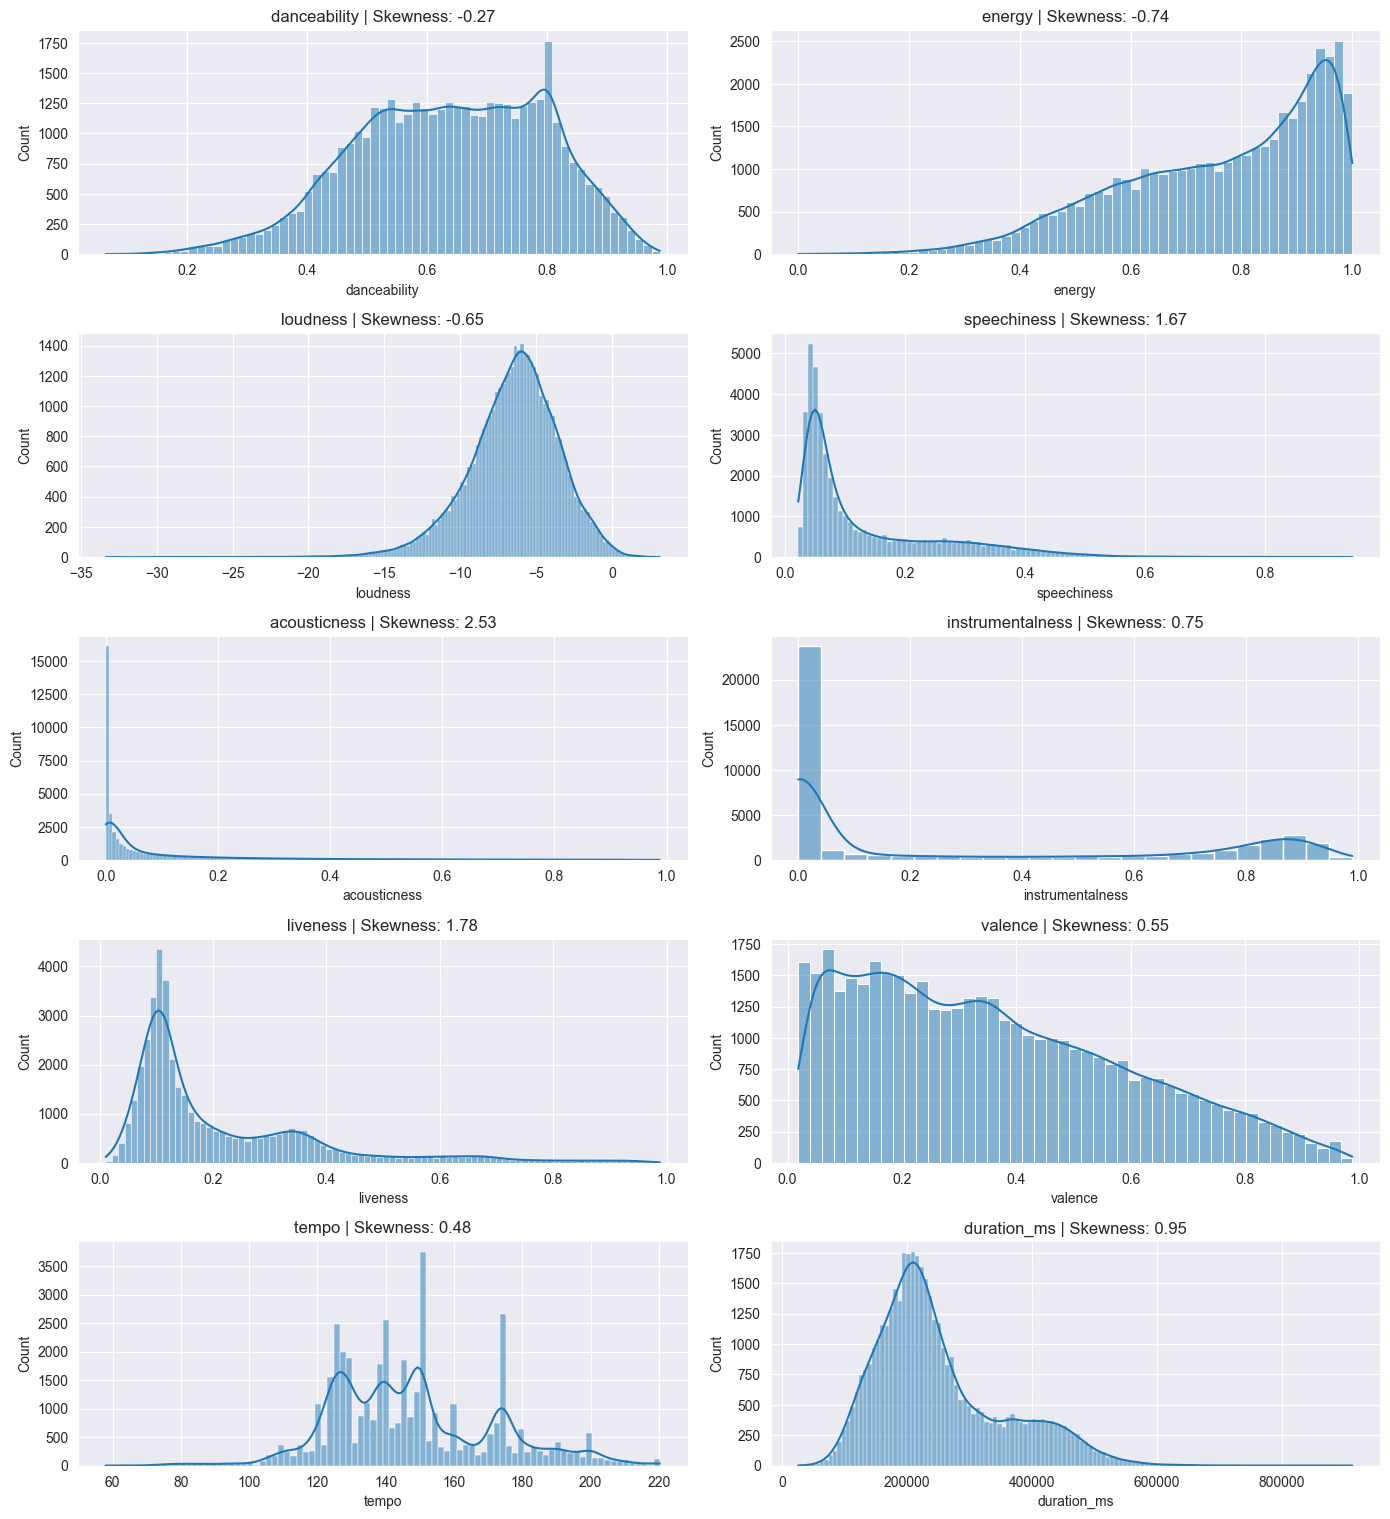

In [520]:
# KDE
skewed_features = {} # Saving for later
plt.figure(figsize=(14, len(numerical_cols) * 3))
print("Highly skewed features:")
for idx, feature in enumerate(numerical_cols, 1):
    plt.subplot(len(numerical_cols), 2, idx)
    sns.histplot(df[feature], kde=True)
    plt.title(f"{feature} | Skewness: {round(df[feature].skew(), 2)}")
    if abs(df[feature].skew()) > 0.7 or abs(df[feature].skew()) < -0.7:
        skewed_features[feature] = df[feature].skew()
        print(f"- {feature} (Skewness: {round(df[feature].skew(), 2)})")
    

plt.tight_layout()
plt.show()

##### Joint Visualizations

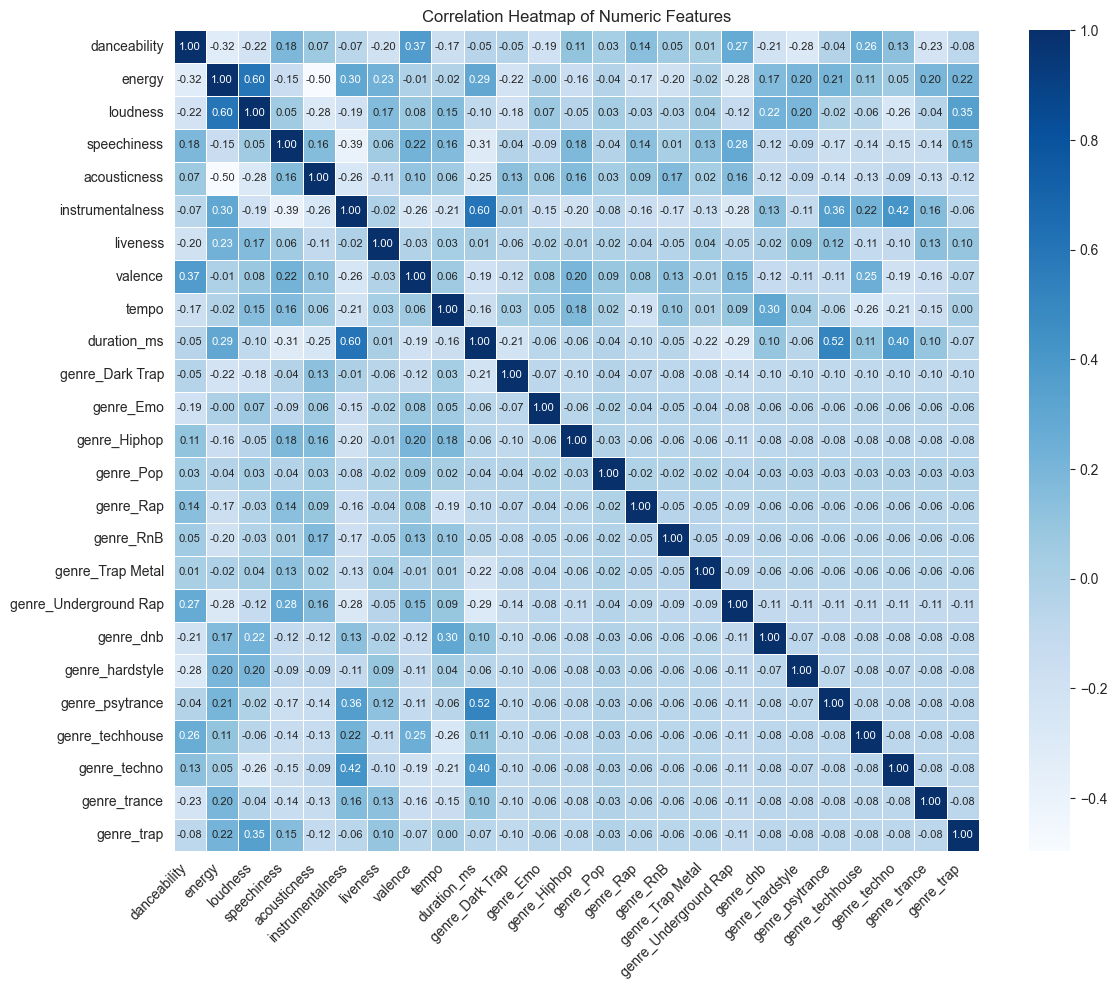

Pairs with corr above 0.4 or below -0.4:



,Feature 1,Feature 2,Correlation
6,duration_ms,instrumentalness,0.603784
4,instrumentalness,duration_ms,0.603784
2,loudness,energy,0.601540
0,energy,loudness,0.601540
8,genre_psytrance,duration_ms,0.518816
7,duration_ms,genre_psytrance,0.518816
9,genre_techno,instrumentalness,0.416939
5,instrumentalness,genre_techno,0.416939
1,energy,acousticness,-0.497334
3,acousticness,energy,-0.497334


In [521]:
# Correlation Heatmap
# Adding genre as dummies to see correlation for specific genres
genre_dummies = pd.get_dummies(df['genre'], prefix='genre')
cor_df = pd.concat([df[numerical_cols], genre_dummies], axis=1)

# Plot
plt.figure(figsize=(12, 10))
correlation_matrix = cor_df.corr()
sns.heatmap(
    correlation_matrix,
    annot=True,
    cmap='Blues',
    fmt=".2f",
    linewidths=.5,
    annot_kws={"size": 8}
)
plt.title('Correlation Heatmap of Numeric Features')
plt.xticks(rotation=45, ha="right")
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

# Looking at high/low correlations
threshold = 0.4
high_corrs = (correlation_matrix.where((correlation_matrix.abs() > threshold) & 
                                       (correlation_matrix.abs() < 1.0)).stack().reset_index())
high_corrs.columns = ['Feature 1', 'Feature 2', 'Correlation']
high_corrs = high_corrs.sort_values(by='Correlation', ascending=False)
high_corrs.columns = ['Feature 1', 'Feature 2', 'Correlation']
high_corrs = high_corrs.sort_values(by='Correlation', ascending=False)
print(f"Pairs with corr above {threshold} or below -{threshold}:\n")
# Just thinking about the display, could probably use a set to avoid duplicates? maybe later
display(high_corrs)

In [522]:
# == SCRAPPED ==
# Keeping one feature for each highly correlated pair
# features_to_drop = ['loudness','duration_ms', 'acousticness']
# df = df.drop(columns=features_to_drop)
# numerical_cols = [col for col in numerical_cols if col not in features_to_drop]
# ==============

# Removing the above features increases silhouette, but i want to see if leaving them makes
# the genres more seperated between clusters -- It actually does, it lowers silhouette but
# the clusters seem to make more sense with genres
print("left over numerical columns for clustering:", numerical_cols)

left over numerical columns for clustering: ['danceability', 'energy', 'loudness', 'speechiness', 'acousticness', 'instrumentalness', 'liveness', 'valence', 'tempo', 'duration_ms']


In [523]:
# After reading a similiar dataset description i think 
# these cols are irrelevant https://www.stat.cmu.edu/capstoneresearch/spring2023/315files_s23/team23.html
# Liveness is literally the detection of a live audience?
useless_cols = ['liveness', 'danceability']
df = df.drop(columns=useless_cols)
numerical_cols = [col for col in numerical_cols if col not in useless_cols]
print("left over numerical columns for clustering:", numerical_cols)

left over numerical columns for clustering: ['energy', 'loudness', 'speechiness', 'acousticness', 'instrumentalness', 'valence', 'tempo', 'duration_ms']


### Pre-Processing

##### Outliers

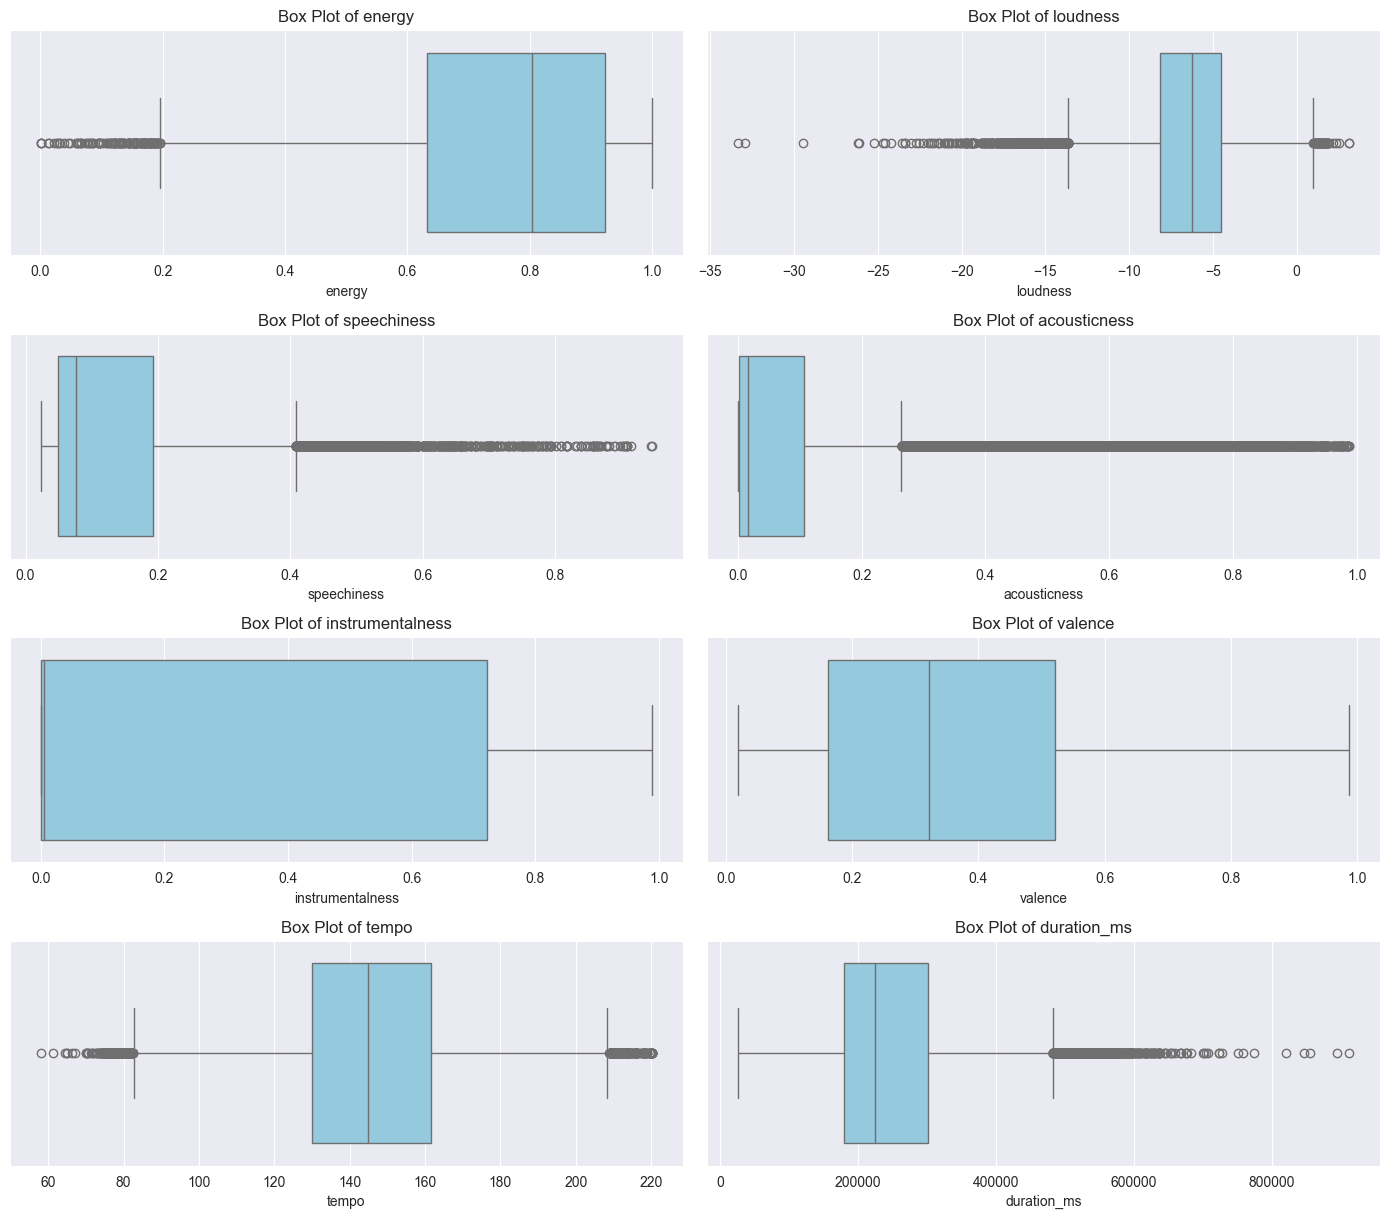

In [524]:
# Box plots for outliers

plt.figure(figsize=(14, len(numerical_cols) * 3))
for idx, feature in enumerate(numerical_cols, 1):
    plt.subplot(len(numerical_cols), 2, idx)
    sns.boxplot(x=df[feature], color='skyblue')
    plt.title(f'Box Plot of {feature}')
plt.tight_layout()
plt.show()

In [525]:
# IQR method, removing outliers and displaying percentage
print("Outlier percentage of numerical features:")
outlier_indices = set()
for col in numerical_cols:
    outliers = []
    Q1 = df[col].quantile(0.25)
    Q2 = df[col].quantile(0.50)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1
    low_lim = Q1 - 1.5 * IQR
    up_lim = Q3 + 1.5 * IQR
    outliers = df[(df[col] < low_lim) | (df[col] > up_lim)]
    outlier_percentage = (len(outliers) / len(df)) * 100
    print(f"- {col}: {outlier_percentage:.2f}%")
    outlier_indices.update(outliers.index) 
    
    
# Badly skewed features
print("\nBadly skewed features:")
for feature, skewness in skewed_features.items():
    print(f"- {feature}: Skewness = {skewness}")
    
# Dropping outliers
print(f"\nShape before dropping outliers: {df.shape}, Total outliers to drop: {len(outlier_indices)}")
df = df.drop(index=outlier_indices)
print(f"Shape after dropping outliers: {df.shape}")

Outlier percentage of numerical features:
- energy: 0.33%
- loudness: 1.88%
- speechiness: 4.53%
- acousticness: 12.17%
- instrumentalness: 0.00%
- valence: 0.00%
- tempo: 1.26%
- duration_ms: 2.88%

Badly skewed features:
- energy: Skewness = -0.7381029885649232
- speechiness: Skewness = 1.6731508303355647
- acousticness: Skewness = 2.5348783320854587
- instrumentalness: Skewness = 0.7526953275935377
- liveness: Skewness = 1.782580248504811
- duration_ms: Skewness = 0.9519100937424495

Shape before dropping outliers: (42305, 11), Total outliers to drop: 8591
Shape after dropping outliers: (33714, 11)


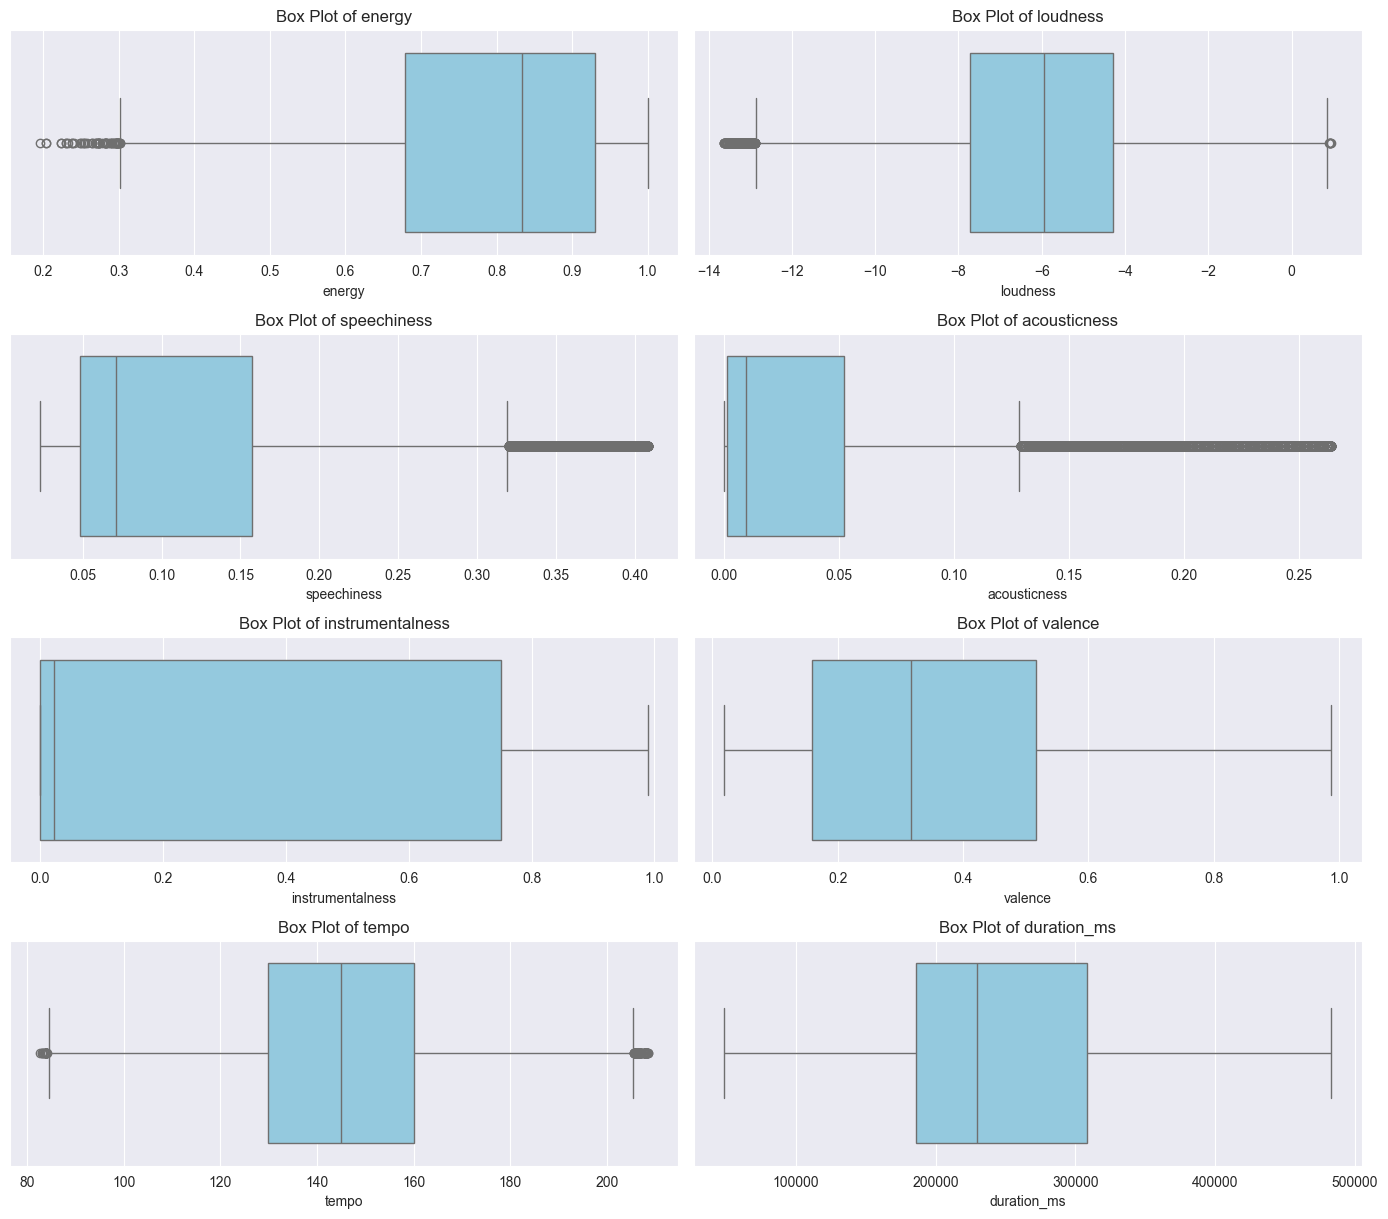

In [526]:
# Box plots for outliers

plt.figure(figsize=(14, len(numerical_cols) * 3))
for idx, feature in enumerate(numerical_cols, 1):
    plt.subplot(len(numerical_cols), 2, idx)
    sns.boxplot(x=df[feature], color='skyblue')
    plt.title(f'Box Plot of {feature}')
plt.tight_layout()
plt.show()

In [527]:
skewed_features = ['speechiness', 'acousticness']

# Log transform highly skewed features
for col in skewed_features:
    if col in df.columns:
        df[col] = np.log1p(df[col])
        
# Didn't add before because it lowered silhouette score, but log tranform as well
# as RobustScaler handles the skewed features better and seperates genres within clusters better


#### Encoding

In [528]:
# No longer need to encode

# Looking at the categorical columns
print(f"Categorical columns before encoding: {categorical_cols}\n")
for col in categorical_cols:
    print(f"Column: {col}")
    
    print(df[col].describe())
    print("\n")
    
# Drop key
df = df.drop(columns=['key']) # Dropping key increased silhouette a lot

# == SCRAPPED ==
# Encoding key
# df = pd.get_dummies(df, columns=['key'], drop_first=True)
# print(f"\nCategorical columns after encoding:")
# print(df.filter(like='key_').head())
# ==============

Categorical columns before encoding: ['key', 'mode', 'genre']

Column: key
count    33714.000000
mean         5.382423
std          3.667976
min          0.000000
25%          1.000000
50%          6.000000
75%          9.000000
max         11.000000
Name: key, dtype: float64


Column: mode
count    33714.000000
mean         0.546628
std          0.497829
min          0.000000
25%          0.000000
50%          1.000000
75%          1.000000
max          1.000000
Name: mode, dtype: float64


Column: genre
count               33714
unique                 15
top       Underground Rap
freq                 4093
Name: genre, dtype: object




#### Scaling

In [529]:
# Looking at the numerical columns
print(f"Numerical columns before scaling: {numerical_cols}\n")
for col in numerical_cols:
    print(f"Column: {col}")
    print(df[col].describe())
    print("\n")
# == SCRAPPED ==
# StandardScaler
# scaler = StandardScaler()
# df[numerical_cols] = scaler.fit_transform(df[numerical_cols])
# Better silhouette score for some reason, but RobustScaler seperates the genres within clusters better
# ==============

scaler = RobustScaler()
df[numerical_cols] = scaler.fit_transform(df[numerical_cols])

print(f"\nNumerical columns after scaling: {numerical_cols}\n")
for col in numerical_cols:
    print(f"Column: {col}")
    print(df[col].describe())
    print("\n")

Numerical columns before scaling: ['energy', 'loudness', 'speechiness', 'acousticness', 'instrumentalness', 'valence', 'tempo', 'duration_ms']

Column: energy
count    33714.000000
mean         0.793652
std          0.160373
min          0.196000
25%          0.679000
50%          0.834000
75%          0.931000
max          1.000000
Name: energy, dtype: float64


Column: loudness
count    33714.000000
mean        -6.074505
std          2.580966
min        -13.627000
25%         -7.724000
50%         -5.949000
75%         -4.291250
max          0.953000
Name: loudness, dtype: float64


Column: speechiness
count    33714.000000
mean         0.107185
std          0.082367
min          0.022935
25%          0.047456
50%          0.068593
75%          0.145830
max          0.342170
Name: speechiness, dtype: float64


Column: acousticness
count    33714.000000
mean         0.037966
std          0.056203
min          0.000001
25%          0.001249
50%          0.009416
75%          0.050788
m

### Training

Training on these cols: ['energy', 'loudness', 'mode', 'speechiness', 'acousticness', 'instrumentalness', 'valence', 'tempo', 'duration_ms']


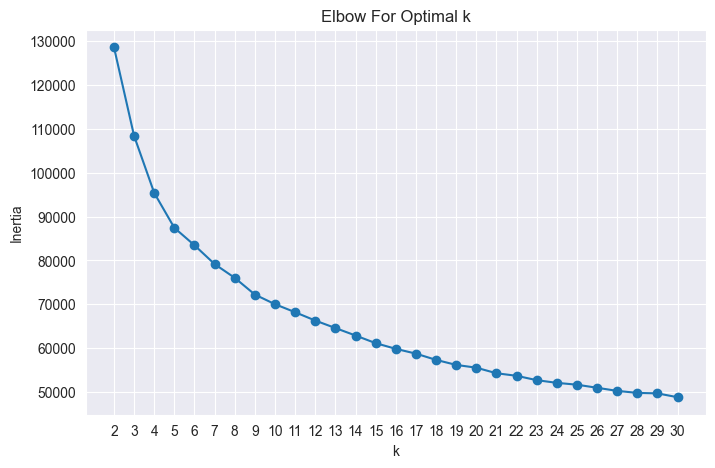

,energy,loudness,mode,speechiness,acousticness,instrumentalness,valence,tempo,duration_ms,genre
3,-0.210317,0.360935,1,0.299274,0.282767,-0.028629,-0.396648,1.387913,-0.861820,Dark Trap
4,-0.833333,-0.500765,1,1.914849,3.774268,-0.028629,0.765363,0.100734,-0.864784,Dark Trap
6,-0.658730,0.520574,1,0.607885,0.316261,-0.018242,-0.779330,-0.466272,-1.238021,Dark Trap
7,-0.488095,0.123516,1,1.332433,0.595828,-0.028629,-0.094972,-0.227635,-0.830280,Dark Trap
9,0.289683,-1.298376,1,2.480579,2.666266,0.012783,-0.041899,1.817215,-0.875553,Dark Trap


In [530]:
# Split genre out of the df for clustering
X = df.drop(columns=['genre'])
y = df['genre']
print("Training on these cols:", X.columns.tolist())

# Elbow method
inertias = []
k_range = range(2, 31)
for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=2406)
    labels = kmeans.fit_predict(X)
    inertias.append(kmeans.inertia_)
    
# Plot the inertia curve
plt.figure(figsize=(8, 5))
plt.plot(k_range, inertias, marker='o')
plt.xlabel('k')
plt.ylabel('Inertia')
plt.title('Elbow For Optimal k')
plt.xticks(k_range)
plt.show()

# Looking at head after clustering
display(df.head())

In [531]:
# From elbow method, going to try 7-11
k_range = (7,8,9,10,11)

# Getting silhouette scores and saving best model as baseline
best_sil_score = -1
baseline_model = None
for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=2406)
    labels = kmeans.fit_predict(X)
    sil_score = silhouette_score(X, labels)
    print(f"Silhouette Score for k={k}: {sil_score:.3f}")
    if sil_score > best_sil_score:
        best_sil_score = sil_score
        baseline_model = kmeans
    
if baseline_model is not None:
    print(f"Best k & Score : {baseline_model.get_params()['n_clusters']} Score: {best_sil_score:.3f}")
    # Add cluster labels to df
    df['cluster'] = baseline_model.labels_

Silhouette Score for k=7: 0.175
Silhouette Score for k=8: 0.174
Silhouette Score for k=9: 0.178
Silhouette Score for k=10: 0.177
Silhouette Score for k=11: 0.174
Best k & Score : 9 Score: 0.178


### Evaluation

c:\Dev\Repos\MLP301-Data-segmentation-using-unsupervised-algorithms\.venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but PCA was fitted with feature names
  warnings.warn(


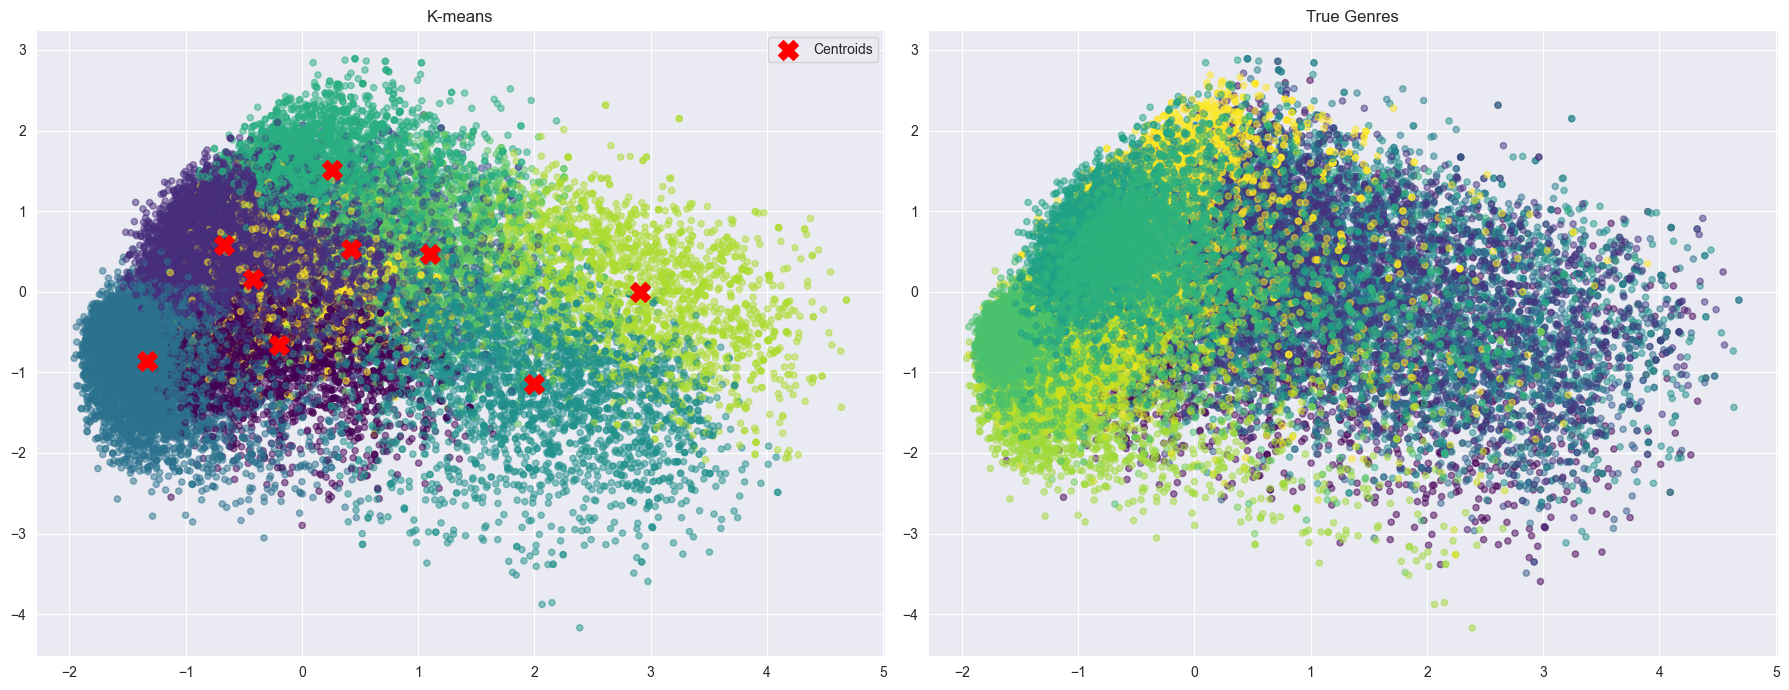

In [532]:
# Visualizing the clusters

# Get rid of warning
if baseline_model is None:
    print("No baseline model found, cannot visualize clusters.")
    exit()

# Reduce to 2D
pca = PCA(n_components=2)
X_reduced = pca.fit_transform(X)

fig, axes = plt.subplots(1, 2, figsize=(18, 7))

# K-means clusters
labels = baseline_model.labels_
centroids = pca.transform(baseline_model.cluster_centers_)
axes[0].scatter(X_reduced[:, 0], X_reduced[:, 1], c=df['cluster'], cmap=colour, alpha=0.5, s=20)
axes[0].set_title('K-means')
axes[0].scatter(centroids[:, 0], centroids[:, 1], c='red', s=200, marker='X', label='Centroids')
axes[0].legend()

# True genres
genre_labels, genre_indices = np.unique(df['genre'], return_inverse=True) 
axes[1].scatter(X_reduced[:, 0], X_reduced[:, 1], c=genre_indices, cmap=colour, alpha=0.5, s=20)
axes[1].set_title('True Genres')

plt.tight_layout()
plt.show()


In [535]:
# Crosstab of clusters v genres
cluster_vs_genre = pd.crosstab(df['cluster'], df['genre'], margins=True, margins_name='Total')
display(cluster_vs_genre)

print (f"Final silhouette score: {best_sil_score:.3f}")
# I think this is the best i can get with K-means, i need to ask a bunch of questions
# Removing features seems to help silhouette a lot, but am i losing important info?

# Looking at the crosstab, it kind of understand a broad sense of the genre based on the fact
# that similar genres seem to be grouped in the same cluster, but its still quite mixed.

genre,Dark Trap,Emo,Hiphop,Pop,Rap,RnB,Trap Metal,Underground Rap,dnb,hardstyle,psytrance,techhouse,techno,trance,trap,Total
cluster,,,,,,,,,,,,,,,,
0,1074,73,170,22,206,131,253,605,17,102,23,320,82,628,67,3773
1,378,376,40,13,25,21,173,112,2202,1882,49,78,16,905,1172,7442
2,296,298,436,84,47,304,149,565,162,2,0,0,0,0,7,2350
3,93,4,4,0,3,1,3,2,147,126,2073,930,2214,935,13,6548
4,546,105,217,76,266,316,140,582,98,225,28,57,125,57,58,2896
5,153,66,173,8,57,56,282,253,216,264,6,14,0,60,1123,2731
6,295,9,425,14,325,174,179,1083,8,6,0,28,9,11,27,2593
7,183,22,432,13,176,176,141,696,14,20,1,6,1,3,33,1917
8,171,397,151,129,84,155,110,195,27,175,28,1472,45,217,108,3464


Final silhouette score: 0.178
